## Theoretical part

### Exercise 1: Hypothesis Testing - the problem of multiple comparisons (5 points)

The type I error occurs in situations where the null hypothesis is rejected while $H_0$ is true and must not be rejected. Thus, the probability of making an incorrect decision on the statisitical significance for a given experiment is $P ($type I error$) = alpha$. Conversely, the probability of the correct rejection of the null hypothesis is $P ($correct $H_0$ rejection$) = 1 - alpha$. <br><br>

(a) We estimate the performance of the m-th experiment to be statistically significant as the previous experiments result insignificant. Therefore, the probability of the m-th experiment to be significant given the previous $m-1$ insignificant experiments can be estimated as follows:<br>
$P ($making a type I error in $(m - 1)$ experiments and not making it in the m-th experiment alone$) = alpha^{m-1}*(1 - alpha)$<br>

(b) For a series of $m$ experiments, we can estimate the probability of having performed at least one significant experiment as the inverse probability of making Type I error in all $m$ tests. Thus, <br>
<br>
$P ($type I error in one experiment$) = alpha$<br>
$P ($type I error in all $m$ experiments) = $P ($at least one FALSE significant experiment in $m$ experiments$) = alpha^m$ <br>
$P ($at least one significant experiment$) = 1 - alpha^m$ <br>
$P ($not making a type I error in all $m$ experiments$) = {(1 - alpha)}^m$ <br>

### Exercise 2: Bias and unfairness in Interleaving experiments (10 points)

The team-draft interleaving method makes an incorrect judgement when, for instance, there exists only one relevant (clicked) document and it is ranked differently by two different algorithms. <br>
Let us consider the following example. Given two ranking algorithms A and B, we assume that these algorithms operate on a collection of three documents ($d_1$, $d_2$, $d_3$) where only one of them (say, $d_3$, is relevant). Hence, algorithm A ranks the documents in the following order: $d_1: N$, $d_2:N$, $d_3:R$ while algorithm B ranks them as follows: $d_2: N$, $d_3:R$, $d_1:N$. Intuitively, algorithm B must win the competition as it assigns a higher rank to the only relevant document. However, this does not take place in reality if the team-draft interleaving method is applied. <br>
As the order of picking the documents is randomized, there exist four possible assignments ("ABA", "ABB", "BAA", "BAB"), which represent the order in which each algorithm (encoded as a literal in a given sequence) picks a preferred document. The resulting rankings are as follows: <br><br>
**ABA**: 
> {$d_1: N$} (from A), {$d_2: N$} (from B), {$d_3: R$} (from A)

**ABB**: 
> {$d_1: N$} (from A), {$d_2: N$} (from B), {$d_3: R$} (from B)

**BAA**: 
> {$d_2: N$} (from B), {$d_1: N$} (from A), {$d_3: R$} (from A)

**BAB**: 
> {$d_2: N$} (from B), {$d_1: N$} (from A), {$d_3: R$} (from B)

We can observe that the only relevant document $d_3$ is ranked to appear third in all the assignments. As a result, the team-draft method considers this situation a tie while it is clear from the initial conditions that algorithm B should be preferred over algorithm A. In conclusion, the case described above represents a situation where the team-draft interleaving method incorrectly evaluates given ranking algorithms.

## Experimental part

### Step 1: Simulate Rankings of Relevance for _E_ and _P_ (5 points)

Given three relevance labels (N, R, and HR), we assume the following relevance scores. Thus, non-relevant documents have a zero score, relevant documents have a score of 1, highly relevant documents are scored 2. Assuming ranking pairs to be of length 5, we then generate $3^5 = 243$ possible rankings for production algorithm P and experimental algorithm E.<br>We can represent the given rankings as an $(n*n)$-matrix, where $n$ is the number of possible rankings for P and E. Given this representation, we can conclude that there must exist $243 * 243 = 59049$ possible ranking pairs of P and E. <br>In this experiment, we are not interested in pairs of rankings that are the same, so we filter those out (243 of them).

In [1]:
import itertools
from collections import Counter
from random import shuffle
import numpy
import random
import math
from scipy.stats import binom_test

relevances = { 'N', 'R', 'HR' }
relevanceScores = { 'N':0, 'R':1, 'HR':2 }
rankingsOf5 = list(itertools.product(relevances, repeat=5))
pairsOfRankingsOf5 = list(itertools.product(rankingsOf5, rankingsOf5))
# remove irrelevant ranking that causes divide by zero errors
pairsOfRankingsOf5.remove((('N','N','N','N','N'),('N','N','N','N','N')))
# remove pairs of rankings that are the same
pairsOfRankingsOf5 = list(filter(lambda pair: pair[0] != pair[1] , pairsOfRankingsOf5))
shuffle(pairsOfRankingsOf5)
print(len(pairsOfRankingsOf5), 'unique pairs of rankings')

58806 unique pairs of rankings


### Step 2: Implement Evaluation Measures (10 points)

As for the evaluation metrics, we have selected to implement average precision, normalised discounted cumulative gain at rank _k_ (nDCG@k), and expected reciprocal rank (ERR). 

In [2]:
def getContingencies (items, k, relevantDocumentCount):
    retrievedCounter = Counter(items[:k])
    TP = retrievedCounter['R'] + retrievedCounter['HR']
    FP = retrievedCounter['N']
    
    notRetrievedCounter = Counter(items[k:])
    TN = notRetrievedCounter['N']
    FN = relevantDocumentCount - TP
    
    return TP, FP, TN, FN

def getPrecisionAtK (ranking, k):
    TP, FP, TN, FN = getContingencies(ranking, k, relevantDocumentCount)
    precisionAtK = TP / (TP + FP)
#     recallAtK = TP / (TP + FN)
#     F1AtK = 2*precisionAtK*recallAtK
#     if F1AtK > 0.0: 
#         F1AtK /= precisionAtK + recallAtK
#     accuracyAtK = (TP + TN)/(TP + FP + FN + TN)
    return precisionAtK

def getAveragePrecision (ranking, relevantDocumentCount):
    precisionsForAp = []
    for k in range(1, len(ranking)+1):
        precisionAtK = getPrecisionAtK(ranking, k)

        if ranking[k-1] == 'R' or ranking[k-1] == 'HR':
            # save for calculating AP later
            precisionsForAp.append(precisionAtK)
    
    averagePrecision = sum(precisionsForAp)/relevantDocumentCount
    return averagePrecision

def getDiscountedCumulativeGain (ranking):
    dcg = 0.0
    for r in range(1, len(ranking)+1):
        relevanceAtR = relevanceScores[ranking[r-1]]
        gain = (2 ** relevanceAtR) - 1
        discount = math.log2(1 + r)
        dcg += gain/discount
    return dcg

def getProbabilityOfRelevance (relevance):
    # from paper, similar to DCG score
    gain = (2 ** relevanceScores[relevance]) - 1
    discount = 2 ** max(relevanceScores.values())
    probability = gain / discount
    return probability

def getExpectedReciprocalRank (ranking):
    err = 0.0
    for r in range(1, len(ranking)+1):
        probabilityOfReachingRankR = 1.0
        for j in range(r-1):
            probabilityOfReachingRankR *= 1 - getProbabilityOfRelevance(ranking[j])
        probabilityOfStoppingAtRankR = getProbabilityOfRelevance(ranking[r-1])
        probabilityOfSatisfaction = probabilityOfReachingRankR * probabilityOfStoppingAtRankR
        expectedProbabilityOfSatisfaction = probabilityOfSatisfaction / r
        err += expectedProbabilityOfSatisfaction
    return err

### Step 3: Calculate $\delta$-measure (10 points)

At the next step, we count the number of pairs where the experimental algorithm outperforms the production algorithm and calculate the difference in performance with respect to all the three pre-selected evaluation metrics for such pairs. 

In [3]:
averagePrecisionsForMapP = []
averagePrecisionsForMapE = []
pairCountForWhichEHasBetterAp = 0
pairCountForWhichEHasBetterNDcgAtK = 0
pairCountForWhichEHasBetterErr = 0
for i, rankingPair in enumerate(pairsOfRankingsOf5):
    P = rankingPair[0]
    E = rankingPair[1]

    totalCounter = Counter(P) + Counter(E)
    relevantDocumentCount = totalCounter['R'] + totalCounter['HR']
    
    # implement 1 of (binary):
    #   precision at rank k
    #   recall at rank k
    #   average precision   <--
    averagePrecisionP = getAveragePrecision(P, relevantDocumentCount)
    averagePrecisionE = getAveragePrecision(E, relevantDocumentCount)
    
    # save for calculating MAP later
    averagePrecisionsForMapP.append(averagePrecisionP)
    averagePrecisionsForMapE.append(averagePrecisionE)
    
    # Normalized Discounted Cumulative Gain
    # First we have to determine the perfect ranking. Assuming the P and E results are always
    # different, and that both algorithms run on the same corpus of documents, the perfect ranking 
    # would include the results from both rankings.
    k = 3
    mergedRanking = P + E
    perfectRanking = sorted(mergedRanking, key=lambda relevance: relevanceScores[relevance], reverse=True)
    perfectDcgScore = getDiscountedCumulativeGain(perfectRanking[:k])
    dcgAtKP = getDiscountedCumulativeGain(P[:k])
    dcgAtKE = getDiscountedCumulativeGain(E[:k])
    nDcgAtKP = dcgAtKP / perfectDcgScore
    nDcgAtKE = dcgAtKE / perfectDcgScore
    
    
    # Expected Reciprocal Rank
    errP = getExpectedReciprocalRank(P)
    errE = getExpectedReciprocalRank(E)
    
    # calculate delta measures
    deltaAp = averagePrecisionE - averagePrecisionP
    deltaNDcgAtK = nDcgAtKE - nDcgAtKP
    deltaErr = errE - errP
    
    # count pairs for which E outperforms P
    epsilon = 1e-6 # avoid floating point imprecisions
    if deltaAp > epsilon:
        pairCountForWhichEHasBetterAp += 1
    if deltaNDcgAtK > epsilon:
        pairCountForWhichEHasBetterNDcgAtK += 1
    if deltaErr > epsilon:
        pairCountForWhichEHasBetterErr += 1
    
    # only show a few
    if i < 5:
        # show the pair
        print ('\nP: ', P, '\nE: ', E)
        print('perfect ranking:\t', perfectRanking)
        print('perfect DCG score:\t', perfectDcgScore)
        print('AP: \t\tP:{:.3f} \tE:{:.3f}'.format(averagePrecisionP, averagePrecisionE))
        print('nDCG@k={}: \tP:{:.3f} \tE:{:.3f}'.format(k, nDcgAtKP, nDcgAtKE))
        print('ERR: \t\tP:{:.3f} \tE:{:.3f}'.format(errP, errE))


# print results

# print how many times E outperformed P
print('\n\nOut of {} rankings, E outperformed P:'.format(len(pairsOfRankingsOf5)-1))
print('AP: \t\t{:.3%}'.format(pairCountForWhichEHasBetterAp/len(pairsOfRankingsOf5)))
print('nDCG@k={}: \t{:.3%}'.format(k, pairCountForWhichEHasBetterNDcgAtK/len(pairsOfRankingsOf5)))
print('ERR: \t\t{:.3%}'.format(pairCountForWhichEHasBetterErr/len(pairsOfRankingsOf5)))
        
# we accidentally implemented MAP instead of just AP, but we'll leave it in
meanAveragePrecisionP = sum(averagePrecisionsForMapP)/len(averagePrecisionsForMapP)
meanAveragePrecisionE = sum(averagePrecisionsForMapE)/len(averagePrecisionsForMapE)
print('MAP \t\tP:{:.3f} \tE:{:.3f}'.format(meanAveragePrecisionP, meanAveragePrecisionE))


P:  ('R', 'HR', 'N', 'R', 'N') 
E:  ('HR', 'N', 'N', 'R', 'R')
perfect ranking:	 ['HR', 'HR', 'R', 'R', 'R', 'R', 'N', 'N', 'N', 'N']
perfect DCG score:	 5.392789260714372
AP: 		P:0.458 	E:0.350
nDCG@k=3: 	P:0.536 	E:0.556
ERR: 		P:0.543 	E:0.775

P:  ('HR', 'N', 'R', 'N', 'R') 
E:  ('N', 'R', 'N', 'R', 'N')
perfect ranking:	 ['HR', 'R', 'R', 'R', 'R', 'N', 'N', 'N', 'N', 'N']
perfect DCG score:	 4.130929753571458
AP: 		P:0.453 	E:0.200
nDCG@k=3: 	P:0.847 	E:0.153
ERR: 		P:0.780 	E:0.172

P:  ('HR', 'HR', 'R', 'N', 'N') 
E:  ('N', 'R', 'N', 'N', 'N')
perfect ranking:	 ['HR', 'HR', 'R', 'R', 'N', 'N', 'N', 'N', 'N', 'N']
perfect DCG score:	 5.392789260714372
AP: 		P:0.750 	E:0.125
nDCG@k=3: 	P:1.000 	E:0.117
ERR: 		P:0.849 	E:0.125

P:  ('HR', 'N', 'N', 'HR', 'N') 
E:  ('N', 'N', 'N', 'R', 'HR')
perfect ranking:	 ['HR', 'HR', 'HR', 'R', 'N', 'N', 'N', 'N', 'N', 'N']
perfect DCG score:	 6.392789260714372
AP: 		P:0.375 	E:0.163
nDCG@k=3: 	P:0.469 	E:0.000
ERR: 		P:0.797 	E:0.175

P:  ('N

### Step 4: Implement Interleaving (15 points)

Having calculated the $\delta$-measures, we proceed by implementing the balanced interleaving method and the team-draft interleaving method for online evaluation of the ranking algorithms. As P and E are assumed to always return different documents, we additionally index each document considered within a ranking pair to distinguish them.

In [4]:
###### STEP 4 ######

#Team Draft Interleaving


#to be able to distinguish the document's assignment, rename the relevances by adding index number
#eg. Ranking pair:  [['HR', 'HR', 'R', 'R', 'N'], ['HR', 'R', 'R', 'N', 'N']]
# Updated pair : (['HR0', 'HR1', 'R2', 'R3', 'N4'], ['HR5', 'R6', 'R7', 'N8', 'N9'])

def preprocess(pair):
    i = 0
    updated_pair = ([], [])
    for relevance in pair[0]:
        updated_pair[0].append(relevance+ str(i))
        i+=1
    
    for relevance in pair[1]:
        updated_pair[1].append(relevance+ str(i))
        i+=1        
    
    return updated_pair


#a) create the interleaving list
def team_draft_interleave(pair):
    pair = preprocess(pair)
    
    A = pair[0]
    B = pair[1]
    interleaved = [] #the interleaving list
    assignments = [] #holds the pair that the documents taken from, "A or B", "0 or 1" respectively
    
    # a somewhat faster implementation that only works for rankings of equal lengths without duplicates
#     for i in range(len(A)): 
#         if random.random() >= 0.5:
#             interleaved.append(A[i])
#             interleaved.append(B[i])
#             assignments.append(0)
#             assignments.append(1)
#         else:
#             interleaved.append(B[i])
#             interleaved.append(A[i])
#             assignments.append(1)
#             assignments.append(0)

    while A or B:
        if A and B:
            first = random.randint(0,1)
        elif A:
            first = 0
        else:
            first = 1
        second = 1 - first

        #pick from the first list(A) then the second list (B)
        if first == 0: #A
            doc = A[0]
            interleaved.append(doc)
            assignments.append(first)
            #delete the doc from the first and the second list
            del A[0] 
            if doc in B:
                B.remove(doc)
            
            #pick from the second list
            doc = B[0]
            interleaved.append(doc)
            assignments.append(second) 
            #delete the doc from the second list (top element) and the first list
            del B[0]
            
            if doc in A:
                A.remove(doc)
            
       #pick from the first list(B) then the second list (A)
        else: #B
            doc = B[0]
            interleaved.append(doc)
            assignments.append(first)
            del B[0]
            if doc in A:
                A.remove(doc)

            #pick from the second list
            doc = A[0]
            interleaved.append(doc)
            assignments.append(second)
            #delete the doc from the first and the second list
            del A[0] 
            if doc in B:
                B.remove(doc)
    
       
    #append the interleaved list with the assignment        
    output = list(zip(interleaved, assignments))
    return output



#generate a list of 'number' amount of random clicks
def random_clicks(length, number):
    clicks = random.sample(range(length), number)
    return clicks

    
#b) evaluate the interleaved list with random clicks


def team_draft_evaluation(interleaved, clicks):
    doc_list, assignments = zip(*interleaved)
    click_nums = [0, 0]
    for i in clicks:
        click_nums[assignments[i]]+=1

    return click_nums[0]-click_nums[1]


pair = [["HR", "HR", "R", "R", "N"], ["HR", "R", "R", "N", "N"]]
print ("Ranking pair: ", pair)
updated_pair = preprocess(pair)
print("Updated pair: ", updated_pair)
interleaved = team_draft_interleave(pair)
print("interleaved: ", interleaved)

clicks = random_clicks(len(interleaved), 3)
print("Random Clicks: ", clicks)

result = team_draft_evaluation(interleaved, clicks)
print("Evaluation A-B (number of clicks): ", result)

Ranking pair:  [['HR', 'HR', 'R', 'R', 'N'], ['HR', 'R', 'R', 'N', 'N']]
Updated pair:  (['HR0', 'HR1', 'R2', 'R3', 'N4'], ['HR5', 'R6', 'R7', 'N8', 'N9'])
interleaved:  [('HR5', 1), ('HR0', 0), ('HR1', 0), ('R6', 1), ('R2', 0), ('R7', 1), ('R3', 0), ('N8', 1), ('N9', 1), ('N4', 0)]
Random Clicks:  [9, 4, 5]
Evaluation A-B (number of clicks):  1


### Step 5: Implement User Clicks Simulation (15 points)

In our experiment, we consider two click models: Random Click Model (RCM) and Simple Dependent Click Model (SDCM). Having browsed the Yandex Click Log File, we observed that there existed some relevant documents had been clicked multiple times. As the selected click models do not take into account multiple clicks for one document, we only consider the first click on such relevant documents and skip the rest.<br>Attractiveness is estimated as the probability of relevance (__refer to the paper here__). Satisfaction is 

In [5]:
### STEP 5 ####

# Yandex Click Log File
def get_sessions():
    f = open('YandexRelPredChallenge.txt', 'r')
    content = []
    for line in f:
        line = line.split()
        content.append(line)
    f.close()

    #each session is a query that has the list of documents retrieved and list of documents that are clicked
    sessions = []  
    for line in content:
        if(line[2]) == 'Q': 
            session = []
            session.append(line[5:])
            session.append([])
            sessions.append(session)
        if(line[2]) == 'C':
            c = line[-1] 
            for i in range(-1, -len(sessions), -1): #attribute the click to the last query that had this document as a result
                session = sessions[i]
                if c in session[0]:
                    sessions[i][1].append(c)
                    break;
    return sessions

sessions = get_sessions()

#Random Click Model


#parameter from the user log
def RCM_parameter(sessions):
    sum1 = 0
    sum2 = 0
    for s in sessions:
        clicks = set()
        for c in s[1]:
            clicks.add(c)
        sum1 += len(clicks)
        sum2 += len(s[0])
        
    p = 1.0*sum1/sum2 
        
    return p


def RCM_clicks(length, p):
    clicks = []
    for i in range(length):
        prob = random.uniform(0, 1)
        if prob < p:
            clicks.append(i)
    return clicks

p = RCM_parameter(sessions)
print(p)

clicks = RCM_clicks(10, p)
print(clicks)

interleaved = [['HR0', 0], ['HR5', 1], ['R6', 1], ['HR1', 0], ['R7', 1], ['R2', 0], ['N8', 1], ['R3', 0], ['N9', 1], ['N4', 0]]

def getProbabilityOfRelevance (relevance):
    # from ERR paper. Very similar to DCG score
    gain = (2 ** relevanceScores[relevance]) - 1
    discount = 2 ** max(relevanceScores.values())
    probability = gain / discount
    return probability

def attractiveness(interleaved):
    attr = []
    for doc in interleaved:
        relevance = doc[0][0]
        if relevance == 'H':
            attr.append(getProbabilityOfRelevance ("HR"))
        if relevance == 'R':
            attr.append(getProbabilityOfRelevance ("R"))
        if relevance == 'N':
            attr.append(getProbabilityOfRelevance ("N"))
    return attr
    


def lambda_r(sessions, r):
    S = list(filter(lambda s: s[0][r-1] in s[1] , sessions))
    total = 0
    for s in S:
        click_index = [s[0].index(page) for page in s[1]]
        last_click = click_index[-1] + 1 #satisfied
        if last_click != r:
            total += 1

    return total/float(len(S))  
    

def get_lambdas(sessions):
    lambdas = []
    for i in range(10):
        lambdas.append(lambda_r(sessions, i+1))
    return lambdas
    

def SDCM_clicks(interleaved, lambdas):
    clicks = []
    attr = attractiveness(interleaved)
    n = len(attr)
    for i in range(1, n):
        prob = random.uniform(0,1)
        
        if prob < attr[i]: #clicked
            clicks.append(i)
            prob = random.uniform(0,1)
            if prob > lambdas[i]: #stop
                break
                
    return clicks

0.12631295132701867
[2, 5]


### Step 6: Simulate Interleaving Experiment (10 points)

_Justification for the code in the section below_

In [6]:
###### STEP 6 #####

# For simulation, we need to run the following piece of code for each pair to get the score
# result : which search engine has higher clicks, A - B, eg. if it is higher than 0, the first one wins
# each run has a different result, so 

pair = [["HR", "HR", "R", "R", "N"], ["HR", "R", "R", "N", "N"]]
sessions = get_sessions()   #gets the sessions as a list from yandex log file
p = RCM_parameter(sessions) #calculates the RCM parameter, MLE
lambdas = get_lambdas(sessions)  #calculates all the lambda values for each rank (1-10)
print("lambdas:{}".format(lambdas))

def simulation_for_pair(pair, click_model):
    interleaved = team_draft_interleave(pair)  #gets the interleaved list
    
    clicks = []
    if click_model == "RCM":
        clicks = RCM_clicks(10, p)  #generates clicks based on RCM model
    elif click_model == "SDCM":
        clicks = SDCM_clicks(interleaved, lambdas) #generates clicks based on RCM model
        
    result = team_draft_evaluation(interleaved, clicks)
    return result


def N_simulation(pair, click_model, N):
    A = 0 #first search engine score
    B = 0 #second search engine score
    
    for i in range(N):
        result = simulation_for_pair(pair, click_model)
        if result > 0:
            A+=1
        if result < 0:
            B+=1
    return A, B

A_score, B_score = N_simulation(pair, "RCM", 100)
print(A_score, B_score)



lambdas:[0.31942931258106355, 0.5378201310303752, 0.5706431189603466, 0.58397365532382, 0.5779661016949152, 0.5579487179487179, 0.5545207605743112, 0.5058619192357794, 0.468378506894912, 0.22727272727272727]
23 32


### Step 7: Results and Analysis (30 points)

In [7]:
# the code in this function is just a copy of the step1-3 code
def getDeltaMeasures (P, E, k):
    totalCounter = Counter(P) + Counter(E)
    relevantDocumentCount = totalCounter['R'] + totalCounter['HR']
    
    # implement 1 of (binary):
    #   precision at rank k
    #   recall at rank k
    #   average precision   <--
    averagePrecisionP = getAveragePrecision(P, relevantDocumentCount)
    averagePrecisionE = getAveragePrecision(E, relevantDocumentCount)
    
    # save for calculating MAP later
    averagePrecisionsForMapP.append(averagePrecisionP)
    averagePrecisionsForMapE.append(averagePrecisionE)
    
    # Normalized Discounted Cumulative Gain
    # First we have to determine the perfect ranking. Assuming the P and E results are always
    # different, and that both algorithms run on the same corpus of documents, the perfect ranking 
    # would include the results from both rankings.
    mergedRanking = P + E
    perfectRanking = sorted(mergedRanking, key=lambda relevance: relevanceScores[relevance], reverse=True)
    perfectDcgScore = getDiscountedCumulativeGain(perfectRanking[:k])
    dcgAtKP = getDiscountedCumulativeGain(P[:k])
    dcgAtKE = getDiscountedCumulativeGain(E[:k])
    nDcgAtKP = dcgAtKP / perfectDcgScore
    nDcgAtKE = dcgAtKE / perfectDcgScore
    
    
    # Expected Reciprocal Rank
    errP = getExpectedReciprocalRank(P)
    errE = getExpectedReciprocalRank(E)
    
    # calculate delta measures
    deltaAp = averagePrecisionE - averagePrecisionP
    deltaNDcgAtK = nDcgAtKE - nDcgAtKP
    deltaErr = errE - errP
    
    return deltaAp, deltaNDcgAtK, deltaErr

In [8]:
from timeit import default_timer as timer
startTime = timer()

# perform an experiment to find correlation between each pair of measures
AP = []
nDCG = []
ERR = []
RCM = []
SDCM = []



k = 5
numberOfRandomTestSets = 100
testSetSize = 20
numberOfInterleavingExperimentsPerPair = 200
measures = ['AP', 'nDCG', 'ERR', 'RCM', 'SDCM']

measurePairAgreementCounts = {}
for measureA in measures:
    measurePairAgreementCounts[measureA] = {}
    for measureB in measures:
        measurePairAgreementCounts[measureA][measureB] = 0
        
for testSetNumber in range(numberOfRandomTestSets):
    if int(100000.0 * (testSetNumber / numberOfRandomTestSets)) % 10000 == 0:
        # every 10 percent
        print("Analyzing test set #{} out of {} at {:.3f} sets per second".format(testSetNumber, numberOfRandomTestSets, testSetNumber/(timer()-startTime)))
    
    # because the whole testset is symmetric, we randomly pick a subset which is 
    # almost guaranteed to be imbalanced (one algorithm is better than the other)
    shuffle(pairsOfRankingsOf5)
    testset = pairsOfRankingsOf5[:testSetSize]
    
    # count the number of wins of each algorithm for each pair in this test set
    winCounts = {}
    for measure in measures:
        winCounts[measure] = [0,0,0]
        
    for pair in testset:
        measureResults = {}
        # collect 5 measures for this pair
        P = pair[0]
        E = pair[1]
        measureResults['AP'], measureResults['nDCG'], measureResults['ERR'] = getDeltaMeasures(P, E, k)
        scoreRcmA, scoreRcmB = N_simulation(pair, "RCM", numberOfInterleavingExperimentsPerPair)
        measureResults['RCM'] = scoreRcmB - scoreRcmA
        scoreSdcmA, scoreSdcmB = N_simulation(pair, "SDCM", numberOfInterleavingExperimentsPerPair)
        measureResults['SDCM'] = scoreSdcmB - scoreSdcmA
        
        
            
        RCM.append(measureResults['RCM'])
        SDCM.append(measureResults['SDCM'])
        AP.append(measureResults['AP'])
        nDCG.append(measureResults['nDCG'])
        ERR.append(measureResults['ERR'])
        
        
        
        # determine winner for each measure
        epsilon = 1e-6 # avoid floating point imprecisions
        for measure, result in measureResults.items():
            if result > epsilon:
                winCounts[measure][2] += 1 # E wins
            elif result < -epsilon:
                winCounts[measure][0] += 1 # P wins
            else:
                winCounts[measure][1] += 1 # draw
        
    # after counting all results for the entire test set, determine overall winner for each measure
    winners = {}
    for measure, counts in winCounts.items():
        if winCounts[measure][0] > winCounts[measure][2]:
            winners[measure] = 'P'
        elif winCounts[measure][0] < winCounts[measure][2]:
            winners[measure] = 'E'
        else:
            winners[measure] = 'draw'
    
    # after determining the winners of the test set, see which measures agree with each other
    for measureA, winnerA in winners.items():
        for measureB, winnerB in winners.items():
            if winnerA == winnerB:
                measurePairAgreementCounts[measureA][measureB] += 1

# after running so many randomized test sets, see how much each measure lines up with the others
rowString = "\t"
for measure in measures:
    rowString += "{}\t".format(measure)
print(rowString)

for measureA, otherMeasures in measurePairAgreementCounts.items():
    rowString = "{}:\t".format(measureA)
    for measureB, agreementCount in otherMeasures.items():
        rowString += "{:.0%}\t".format(agreementCount/numberOfRandomTestSets)
    print(rowString)

Analyzing test set #0 out of 100 at 0.000 sets per second
Analyzing test set #10 out of 100 at 1.382 sets per second
Analyzing test set #20 out of 100 at 1.377 sets per second
Analyzing test set #30 out of 100 at 1.349 sets per second
Analyzing test set #40 out of 100 at 1.356 sets per second
Analyzing test set #50 out of 100 at 1.360 sets per second
Analyzing test set #60 out of 100 at 1.364 sets per second
Analyzing test set #70 out of 100 at 1.367 sets per second
Analyzing test set #80 out of 100 at 1.370 sets per second
Analyzing test set #90 out of 100 at 1.372 sets per second
	AP	nDCG	ERR	RCM	SDCM	
AP:	100%	49%	47%	51%	49%	
nDCG:	49%	100%	64%	29%	58%	
ERR:	47%	64%	100%	33%	46%	
RCM:	51%	29%	33%	100%	37%	
SDCM:	49%	58%	46%	37%	100%	


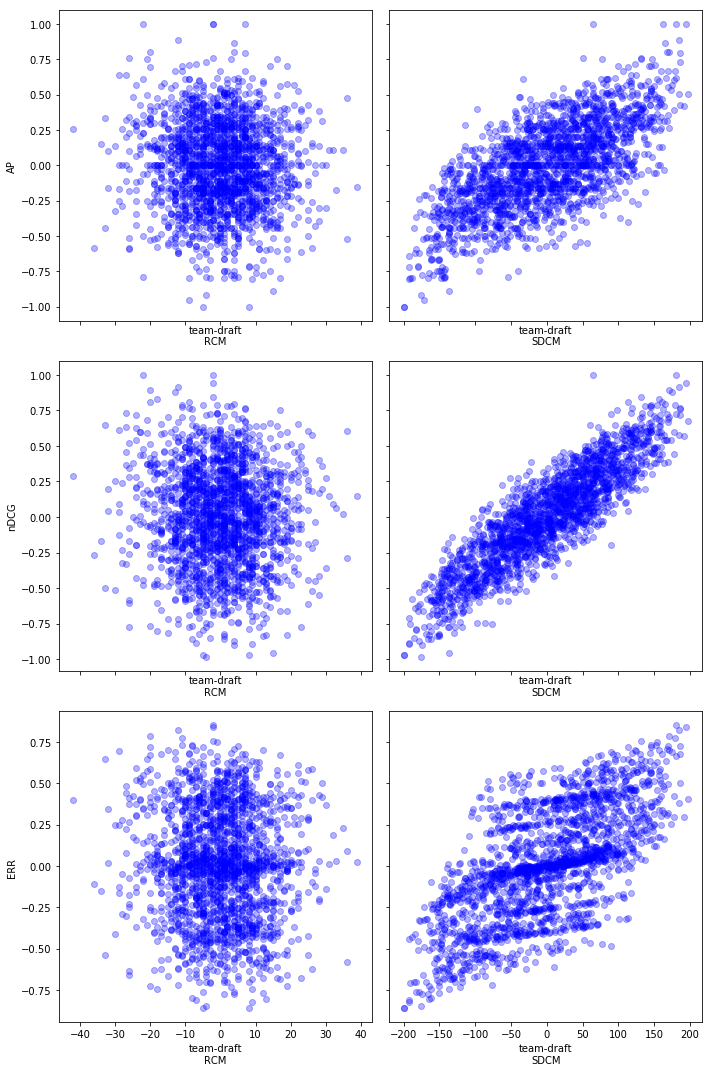

In [9]:
import matplotlib
import matplotlib.pyplot as plt

offline_names = ["AP", "nDCG", "ERR"]
clickModels = ["RCM", "SDCM"]

scores = []
scores.append([AP, nDCG, ERR])
scores.append([RCM, SDCM])



def plot_correlations(scores):
    f, (ax) = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(10, 15))

    for k in range(3):
        offline_values = scores[0][k]
        ax[k][0].set_ylabel(offline_names[k])

        for j in range(2):
            online_values =  scores[1][j]
            ax[k][j].plot(online_values, offline_values, 'bo', alpha=0.3)

            
            ax[k][j].set_xlabel("team-draft" + '\n' + clickModels[j])

            plt.tight_layout()
    plt.show()
    
plot_correlations(scores)

In [10]:
from scipy.stats.stats import pearsonr

print('Pearson correlation coefficient between Offline and Online measures:\n')

pcc_ap_rcm = pearsonr(AP, RCM)
print('AP and RCM : ', pcc_ap_rcm[0])

pcc_dcg_rcm = pearsonr(nDCG, RCM)
print('nDCG and RCM : ', pcc_dcg_rcm[0])

pcc_err_rcm = pearsonr(ERR, RCM)
print('ERR and RCM :  ', pcc_err_rcm[0])

pcc_ap_sdcm = pearsonr(AP, SDCM)
print('AP and SDCM : ', pcc_ap_sdcm[0])

pcc_dcg_sdcm = pearsonr(nDCG, SDCM)
print('nDCG and SDCM : ', pcc_dcg_sdcm[0])

pcc_err_sdcm = pearsonr(ERR, SDCM)
print('ERR and SDCM : ', pcc_err_sdcm[0])





Pearson correlation coefficient between Offline and Online measures:

AP and RCM :  -0.0507639042613
nDCG and RCM :  -0.0517807712654
ERR and RCM :   -0.0451984867004
AP and SDCM :  0.679583831551
nDCG and SDCM :  0.889233577212
ERR and SDCM :  0.664256608262


### Result and Analysis

The aim of this project was to estimate the degree of agreement between online and offline evaluation metrics for different ranking algorithms. To do so, we simulated two information retrieval algorithms, evaluated their performance by calculating the measures mentioned below and estimated the correlations between each pair of these measures. The following evaluation measures were used in our experiments: <br>

Offline Measures:
- Average Precision (AP)
- Normalised Discounted Cumulative Gain (nDCG)
- Expected Reciprocal Rank (ERR)

Online Measures:
- Random Click Model (RCM)
- Simple Dependent Click Model (SDCM)

The performed experiments have been designed as follows. Our estimation of the degree of agreement is based on using a large number of randomized shuffled subsets of the previously generated ranking pairs. The aforementioned evaluation measures are then calculated for each pair within each test set. Subsequently, the winners were singled out for each evaluation measure. The degree of agreement between two different measures was then estimated as a proportion of wins where both compared metrics pointed to the same winner.

The obtained results allow us to make the following conclusions:

For instance, our random click models show no correlation with the considered offline measures. The calculated pearson's correlation coefficients confirm the weakness of the respective correlations (if any) which follows the results of the performed experiments. Conversely, the SDCM shows strong correlation with the offline measures. In particular, we can observe a significant correlation between nDCG and SDCM (~ 0.9). We hypothesize that it is because the probability of relevance is calculated with almost the same formula as the nDCG score. 

In general, the offline measures appear to predict wins more consistently and therefore can be used interchangeably, which does not hold in the case of the considered online measures. The distribution of the results obtained through RCM happens to be non-consistent with the other measures. Thus, as expected, random click models do not seem to discriminate adequatly between different ranking algorithms.

Our experiment shows that team drafting with SDCM is a similarly effective measure for evaluating the performance of different ranking algorithms compared to the considered offline measures.
